In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.wrappers import LdaMallet

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim 
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [3]:
df=pd.read_csv('got_scripts_breakdown.csv', sep=';')
df.head()

,Column1,Season,Episode,Sentence,Name,N_serie,N_Season,Emision Date
0,1,Season 1,winter is coming,What d’you expect? They’re savages One lot ste...,waymar royce,1,1,17/04/2011
1,2,Season 1,winter is coming,I’ve never seen wildlings do a thing like this...,will,1,1,17/04/2011
2,3,Season 1,winter is coming,How close did you get?,waymar royce,1,1,17/04/2011
3,4,Season 1,winter is coming,Close as any man would,will,1,1,17/04/2011
4,5,Season 1,winter is coming,We should head back to the wall,gared,1,1,17/04/2011


In [4]:
# Convert to list
data = df.Sentence.values.tolist()

In [5]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['what', 'you', 'expect', 'they', 're', 'savages', 'one', 'lot', 'steals', 'goat', 'from', 'another', 'lot', 'and', 'before', 'you', 'know', 'it', 'they', 're', 'ripping', 'each', 'other', 'to', 'pieces']]


In [6]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['what', 'you', 'expect', 'they', 're', 'savages', 'one', 'lot', 'steals', 'goat', 'from', 'another', 'lot', 'and', 'before', 'you', 'know', 'it', 'they', 're', 'ripping', 'each_other', 'to', 'pieces']


In [7]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [8]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['expect', 'savage', 'lot', 'steal', 'goat', 'lot', 'know', 'rip', 'piece']]


In [9]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1)]]


In [10]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('expect', 1),
  ('goat', 1),
  ('know', 1),
  ('lot', 2),
  ('piece', 1),
  ('rip', 1),
  ('savage', 1),
  ('steal', 1)]]

In [39]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=24, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           eta=0.1,
                                           per_word_topics=True)

In [12]:
# Print the Keyword in the 20 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.095*"way" + 0.076*"stand" + 0.051*"murder" + 0.046*"fuck" + 0.045*"try" + '
  '0.043*"child" + 0.039*"mean" + 0.031*"city" + 0.029*"pull" + '
  '0.023*"choose"'),
 (1,
  '0.082*"never" + 0.058*"hand" + 0.057*"ever" + 0.051*"cersei" + 0.045*"war" '
  '+ 0.041*"head" + 0.039*"world" + 0.031*"talk" + 0.027*"life" + '
  '0.023*"stay"'),
 (2,
  '0.119*"want" + 0.092*"father" + 0.070*"fight" + 0.053*"dragon" + '
  '0.052*"army" + 0.034*"let" + 0.023*"home" + 0.022*"gold" + 0.021*"nice" + '
  '0.020*"hold"'),
 (3,
  '0.179*"s" + 0.137*"look" + 0.106*"think" + 0.059*"right" + 0.050*"die" + '
  '0.033*"face" + 0.032*"happen" + 0.031*"line" + 0.030*"ask" + 0.023*"bran"'),
 (4,
  '0.191*"man" + 0.080*"king" + 0.069*"arya" + 0.042*"sansa" + 0.040*"great" + '
  '0.040*"help" + 0.035*"sister" + 0.028*"betray" + 0.018*"open" + '
  '0.018*"castle"'),
 (5,
  '0.135*"take" + 0.107*"jon" + 0.059*"love" + 0.033*"anything" + '
  '0.031*"enough" + 0.030*"tree" + 0.028*"else" + 0.026*"kings_lande" 

In [13]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.07591817046366

Coherence Score:  0.3455556277302172


In [14]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10    -0.404949  0.135267       1        1  11.243542
2     -0.038719 -0.098997       2        1   6.684388
13    -0.103126  0.000285       3        1   6.650755
9     -0.050196 -0.327866       4        1   5.917062
8      0.011053 -0.006115       5        1   5.730511
1     -0.014604  0.032162       6        1   5.670709
3     -0.036335 -0.202610       7        1   5.661371
4      0.009016 -0.018148       8        1   5.551409
7      0.024001  0.006778       9        1   5.002184
17     0.032866  0.049804      10        1   4.936365
11     0.027633  0.031709      11        1   4.789360
12     0.009764  0.036934      12        1   4.604970
6      0.059829  0.041581      13        1   4.516101
0      0.030097  0.038697      14        1   4.468823
18     0.042553  0.040869      15        1   4.362446
19     0.055556  0.049264      16        1   3.949034
5      0.064884  0.038712      17        1   3.869786
15     0.089353  0.052572      18        1   2.694342
16     0.095273  0.049456      19        1   2.280146
14     0.096049  0.049646      20        1   1.416692, topic_info=     Category         Freq       Term        Total  loglift  logprob
560   Default  2966.000000        not  2966.000000  30.0000  30.0000
558   Default  2149.000000         be  2149.000000  29.0000  29.0000
53    Default  1823.000000         do  1823.000000  28.0000  28.0000
16    Default  1360.000000        man  1360.000000  27.0000  27.0000
2     Default  1322.000000       know  1322.000000  26.0000  26.0000
571   Default  1296.000000          s  1296.000000  25.0000  25.0000
90    Default  1076.000000       come  1076.000000  24.0000  24.0000
11    Default  1077.000000        see  1077.000000  23.0000  23.0000
48    Default  1040.000000         go  1040.000000  22.0000  22.0000
112   Default   990.000000       look   990.000000  21.0000  21.0000
44    Default  1018.000000       want  1018.000000  20.0000  20.0000
15    Default   912.000000        get   912.000000  19.0000  19.0000
679   Default   934.000000       have   934.000000  18.0000  18.0000
42    Default   713.000000        say   713.000000  17.0000  17.0000
80    Default   757.000000       lord   757.000000  16.0000  16.0000
91    Default   730.000000       tell   730.000000  15.0000  15.0000
29    Default   767.000000      think   767.000000  14.0000  14.0000
151   Default   667.000000       take   667.000000  13.0000  13.0000
18    Default   716.000000       back   716.000000  12.0000  12.0000
49    Default   785.000000     father   785.000000  11.0000  11.0000
714   Default   682.000000       walk   682.000000  10.0000  10.0000
33    Default   686.000000       kill   686.000000   9.0000   9.0000
414   Default   686.000000       make   686.000000   8.0000   8.0000
102   Default   622.000000       need   622.000000   7.0000   7.0000
116   Default   574.000000      north   574.000000   6.0000   6.0000
40    Default   561.000000       good   561.000000   5.0000   5.0000
12    Default   585.000000      thing   585.000000   4.0000   4.0000
72    Default   533.000000        jon   533.000000   3.0000   3.0000
10    Default   598.000000      never   598.000000   2.0000   2.0000
210   Default   543.000000      queen   543.000000   1.0000   1.0000
...       ...          ...        ...          ...      ...      ...
1072  Topic20   107.245987       crow   108.860291   4.2419  -2.8274
598   Topic20    97.192566    already    98.802689   4.2404  -2.9258
0     Topic20    70.626976     expect    72.237030   4.2343  -3.2451
3     Topic20    70.011086        lot    71.621147   4.2341  -3.2539
93    Topic20    69.627190      young    71.237289   4.2340  -3.2594
104   Topic20    64.442810      sorry    66.052773   4.2322  -3.3367
903   Topic20    44.272343    quickly    45.883251   4.2211  -3.7122
305   Topic20    43.356419     clever    44.966698   4.2204  -3.7331
7     Top

In [ ]:
#### Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
# mallet_path = '/Users/joycechen/Desktop/ML/SM_Project/mallet-2.0.8/bin/mallet'  # update this path
# ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [15]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
#         model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           eta=0.1,
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [35]:

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=20, limit=30, step=2)


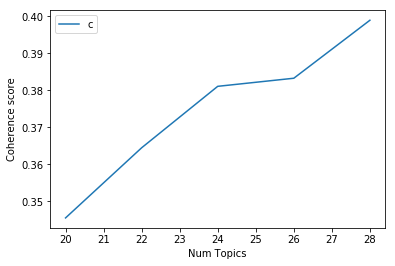

In [36]:
# Show graph
limit=30; start=20; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [37]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 20  has Coherence Value of 0.3456
Num Topics = 22  has Coherence Value of 0.3645
Num Topics = 24  has Coherence Value of 0.3811
Num Topics = 26  has Coherence Value of 0.3833
Num Topics = 28  has Coherence Value of 0.399


In [38]:
# Select the model and print the topics
optimal_model = model_list[2] 
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(11,
  '0.103*"love" + 0.095*"enemy" + 0.064*"burn" + 0.046*"crow" + 0.037*"defeat" '
  '+ 0.037*"snow" + 0.035*"flame" + 0.033*"defend" + 0.028*"sorry" + '
  '0.024*"joke"'),
 (20,
  '0.184*"back" + 0.089*"wall" + 0.051*"gendry" + 0.046*"send" + 0.037*"put" + '
  '0.034*"heart" + 0.032*"bastard" + 0.028*"wildling" + 0.025*"order" + '
  '0.024*"weapon"'),
 (2,
  '0.070*"face" + 0.069*"child" + 0.068*"happen" + 0.058*"start" + '
  '0.057*"boat" + 0.048*"girl" + 0.046*"pull" + 0.042*"enough" + 0.040*"true" '
  '+ 0.028*"soon"'),
 (21,
  '0.141*"good" + 0.136*"queen" + 0.077*"winterfell" + 0.066*"hear" + '
  '0.060*"bring" + 0.037*"bronn" + 0.037*"ride" + 0.027*"beach" + '
  '0.027*"raven" + 0.015*"arrive"'),
 (12,
  '0.207*"have" + 0.102*"stand" + 0.098*"leave" + 0.064*"help" + 0.053*"mean" '
  '+ 0.032*"destroy" + 0.028*"bear" + 0.024*"continue" + 0.021*"alone" + '
  '0.019*"iron_island"'),
 (19,
  '0.155*"take" + 0.121*"dead" + 0.046*"betray" + 0.041*"home" + 0.034*"tree" '
  '+ 0.030